In [73]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.preprocessing import MinMaxScaler,RobustScaler

# Keras / Deep Learning
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam
"""

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator
import numpy as np

In [10]:
%%time
df = spark.read.csv("hdfs://master:9000/user/data/rds_cpu_utilization_e47b3b.csv", inferSchema=True, header=True).rdd
# inferSchema referring to the type of the column


CPU times: user 0 ns, sys: 3.43 ms, total: 3.43 ms
Wall time: 541 ms


In [35]:
test = df.collect()
#len(test)
test[0][1]

14.012

In [49]:
#init a 60ts list
slide_win = test[:60]

for i in test[60:]:
    slide_win.pop(0)
    slide_win.append(i)
    print(slide_win)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[Row(timestamp=datetime.datetime(2014, 4, 22, 16, 42), value=16.6675), Row(timestamp=datetime.datetime(2014, 4, 22, 16, 47), value=17.9175), Row(timestamp=datetime.datetime(2014, 4, 22, 16, 52), value=15.835), Row(timestamp=datetime.datetime(2014, 4, 22, 16, 57), value=17.9025), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 2), value=17.065), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 7), value=17.085), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 12), value=16.6675), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 17), value=17.0825), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 22), value=16.6875), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 27), value=17.9725), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 32), value=17.0825), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 37), value=18.39), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 42), value=16.5775), Row(timestamp=datetime.datetime(2014, 4, 22, 17, 47), value=17.0825), Row(timestamp=datetime.da

In [72]:
#select
def select_features(data_list):
    return np.array(data_list)[:,1:2]

array([[14.012],
       [13.334000000000001],
       [15.0],
       [13.998],
       [14.332],
       [15.002],
       [13.984000000000002],
       [14.674000000000001],
       [14.668],
       [13.665999999999999],
       [13.334000000000001],
       [15.046],
       [13.332],
       [15.0],
       [15.0],
       [14.368],
       [13.665999999999999],
       [15.332],
       [14.334000000000001],
       [14.335999999999999],
       [14.0],
       [14.332],
       [13.332],
       [14.998],
       [13.665999999999999],
       [13.67],
       [14.668],
       [14.334000000000001],
       [14.304],
       [15.038],
       [13.665999999999999],
       [14.334000000000001],
       [14.0],
       [14.665999999999999],
       [13.0],
       [14.334000000000001],
       [14.658],
       [14.0],
       [14.318],
       [14.277999999999999],
       [14.706],
       [14.334000000000001],
       [14.0],
       [14.694],
       [14.334000000000001],
       [14.002],
       [13.716],
       [13.962

In [83]:

#slide_win
#features_scale i:np_data_list o:scaler & scaled data
def features_scale(np_data_list):
    window_scaler = RobustScaler()
    np_data_list_scale = window_scaler.fit_transform(np_data_list)
    return window_scaler,np_data_list_scale

def model_predict(model, np_data_list):
    np_data_list = np.reshape(np_data_list,(1,60,1))
    return model.predict(np_data_list)

model = load_model("Model/20201231_233317_MEM_used_stack_LSTM_0.59MAE_1.62RMSE.h5")
data = select_features(slide_win)
scaler,scaler_data = features_scale(data)
predict_traffic = model_predict(model,scaler_data)
predict_traffic

array([[-0.3804464]], dtype=float32)

In [85]:
stages = []

model = load_model("Model/20201231_233317_MEM_used_stack_LSTM_0.59MAE_1.62RMSE.h5")

data = select_features(slide_win)
scaler,scaler_data = features_scale(data)
predict_traffic = model_predict(model,scaler_data)

stages += [data, scaler_data,predict_traffic]

# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(slide_win)

# Transform Data using Fitted Pipeline
#df_transform = pipeline_model.transform(slide_win)


TypeError: Cannot recognize a pipeline stage of type <class 'numpy.ndarray'>.

In [94]:
# Helper function to select features to scale given their skew
def select_features_to_scale(df=df, drop_cols=['Date','time','Allocate memory']):
    
    # Empty Selected Feature List for Output
    selected_features = []
    
    # Select Features to Scale based on Inputs ('in32' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(df.toPandas().columns.drop(drop_cols))
    
    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        selected_features.append(feature)
        #if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:
            
            
    
    # Return feature list to scale
    return selected_features

In [102]:
def sliding(rdd, n):
    assert n > 0
    def gen_window(xi, n):
        x, i = xi
        return [(i - offset, (i, x)) for offset in xrange(n)]

    return (
        rdd.
        zipWithIndex("timestamp"). # Add index
        flatMap(lambda xi: gen_window(xi, n)). # Generate pairs with offset
        groupByKey(). # Group to create windows
        # Sort values to ensure order inside window and drop indices
        mapValues(lambda vals: [x for (i, x) in sorted(vals)]).
        sortByKey(). # Sort to makes sure we keep original order
        values(). # Get values
        filter(lambda x: len(x) == n)) # Drop beginning and end

In [103]:
"""
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, 0])
        y_train.append(data[i:i+y_window_size, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    
    return X_train,y_train
"""

'\ndef gen_dataset(data,x_window_size,y_window_size):\n    X_train = []   #預測點的前 60 天的資料\n    y_train = []   #預測點\n    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):\n        X_train.append(data[i-x_window_size:i, 0])\n        y_train.append(data[i:i+y_window_size, 0])\n\n    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN\n    \n    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))\n    \n    \n    return X_train,y_train\n'

In [95]:
stages = []

unscaled_features = select_features_to_scale(df=df_data)
unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="unscaled_features", outputCol="scaled_features")



stages += [unscaled_assembler, scaler]

TypeError: __init__() got an unexpected keyword argument 'min'

In [105]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(df)

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(df)

In [106]:
test_list = []
np_dataset = np.array(df_transform.select('scaled_features').collect())

test_list.append(np_dataset[:60])
#np.array(test_list).shape
np_dataset.shape

(4032, 1, 1)

In [107]:
def gen_dataset(np_data,x_window_size,y_window_size):
    X_data = []
    y_data = []
    for i in range(x_window_size, np_data.shape[0]-y_window_size,y_window_size):
        X_data.append(np_data[i-x_window_size:i])
        y_data.append(np_data[i:i+1])
    
    X = np.array(X_data)
    y = np.array(y_data)
    X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2]))
    y = np.reshape(y,(y.shape[0],y.shape[1],y.shape[2]))
    return X,y

X_test,y_test = gen_dataset(np_dataset,60,1)




In [114]:
model = load_model("Model/20201231_233317_MEM_used_stack_LSTM_0.59MAE_1.62RMSE.h5")

In [115]:
#1231progress
import matplotlib.pyplot as plt 

pred_data = model.predict(X_test)



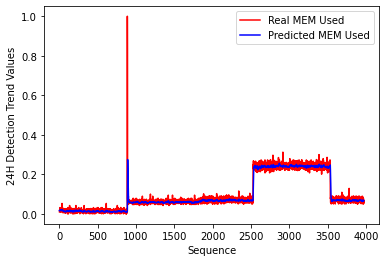

In [117]:

plt.plot(np.reshape(y_test,(y_test.shape[0],1)),color = 'red', label = 'Real MEM Used')
plt.plot(pred_data,color = 'blue', label = 'Predicted MEM Used')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.legend()

In [88]:
df_transform_fin = df_transform.select('scaled_features')

In [89]:
df_transform_fin

DataFrame[scaled_features: vector]

In [94]:
X_train_input_dim1 = 60
X_train_input_dim2 = 1

model = Sequential()
model.add(LSTM(60, input_shape=(X_train_input_dim1, X_train_input_dim2),return_sequences=True,unroll=True,activation='relu'))

model.add(LSTM(60, return_sequences=False,unroll=True,activation='relu'))

model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)